Forecast Annual Visition at Utah National Parks

In [1]:
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt

# Ingest Data

Visition data for each park is stored in its own csv file. We collect all data into a single pandas dataframe

In [2]:
#all files in directory
all_files = os.listdir()

#just the csv's with data
csv_files = [file for file in all_files if file.endswith(".csv")]

In [3]:
#initialize the final dataset and types

#set columns and types
data = ['ts', 'visitors', 'park']

#make dataframe
df_visit = pd.DataFrame(columns=data)

In [4]:
#loop through datasets

for f in csv_files:

    #extract name of park from data
    park_name = pd.read_csv(f, nrows=1).iloc[0,0]
    #trim the ' NP' from park name
    park_name = park_name[:-3]

    #read data
    df = pd.read_csv(f, skiprows=3)
    #drop last column since it's a row-wise sum
    df.drop(df.columns[-1], axis=1, inplace=True)
    #rename id column
    df.rename(columns={'Year':'year'}, inplace=True)

    #pivot data
    df_pivot = df.melt(id_vars='year', var_name='month_abbr', value_name='visitors').dropna()

    #clean data
    #extract month number from month name
    def extract_month_number(month_name):
        return pd.to_datetime(month_name, format='%b').month
    
    df_pivot['month_num'] = df_pivot['month_abbr'].apply(extract_month_number)
    #make timestamp
    df_pivot['ts'] = pd.to_datetime(dict(year=df_pivot.year, month=df_pivot.month_num, day=1))
    #convert visitors to numeric
    df_pivot['visitors'] = pd.to_numeric(df_pivot['visitors'].str.replace(',', ''))
    #add park identifier
    df_pivot['park'] = park_name
    #select needed columns
    df_final = df_pivot[['ts', 'visitors', 'park']]

    df_visit = pd.concat([df_visit, df_final], ignore_index=True)

In [5]:
#clean data types
df_visit = df_visit.convert_dtypes()

# Exploratory Data Analysis

In [52]:
#set colors
#use brand colors of Mighty 5 campaign (https://www.visitutah.com/places-to-go/parks-outdoors/the-mighty-5)
orange = '#ed6417'
d_blue = '#012d50'
red = '#772116'
l_blue = '#51b8f3'
gray = '#516c85'

colors = [orange, d_blue, red, l_blue, gray]



We have data starting in 1979 for each park. Each has a monthly observation through March 2024

In [8]:

(
    df_visit
    .groupby('park')
    .agg(
        tot_visitors=('visitors', 'sum'),
        ts_min=('ts', 'min'),
        ts_max=('ts', 'max'),
        tot_months=('ts', 'count')
    )
    .sort_values('tot_visitors', ascending=False)
)

,tot_visitors,ts_min,ts_max,tot_months
park,,,,
Zion,119799075,1979-01-01,2024-03-01,543
Bryce Canyon,54430540,1979-01-01,2024-03-01,543
Arches,39894589,1979-01-01,2024-03-01,543
Capitol Reef,30093495,1979-01-01,2024-03-01,543
Canyonlands,18593469,1979-01-01,2024-03-01,543


Visitation grew in the late 80's and stabilized for about 20 years. It then spiked in the 2010's with the Mighty 5 campaign.

There was a dip in 2020 due to covid retrictions

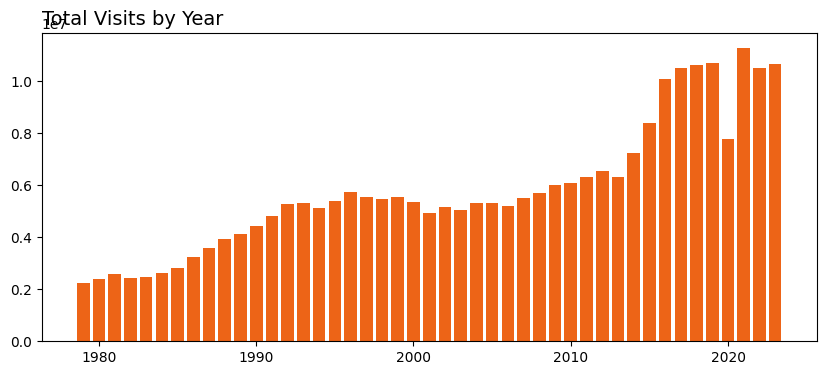

In [31]:
visits_by_year = (
    df_visit
    .loc[(df_visit['ts'].dt.year < 2024)] #filter current year since it's incomplete
    .groupby(df_visit['ts'].dt.year)
    .agg(
        tot_visitors=('visitors', 'sum')
    )
    .reset_index()
    .rename(columns={'ts':'year'})
)

# Create the bar plot
fig, ax = plt.subplots(figsize=(10,4))

ax.bar(visits_by_year['year'], visits_by_year['tot_visitors'], color=[orange])

ax.set_title(
    'Total Visits by Year',
    fontsize=14,
    loc='left'
)

# Display the plot
plt.show()



All parks experienced a similar growth trend in visitation.   
The ranking of the parks has remained stable for nearly the whole dataset. Zion is almost the most visited and Canyonlands the least

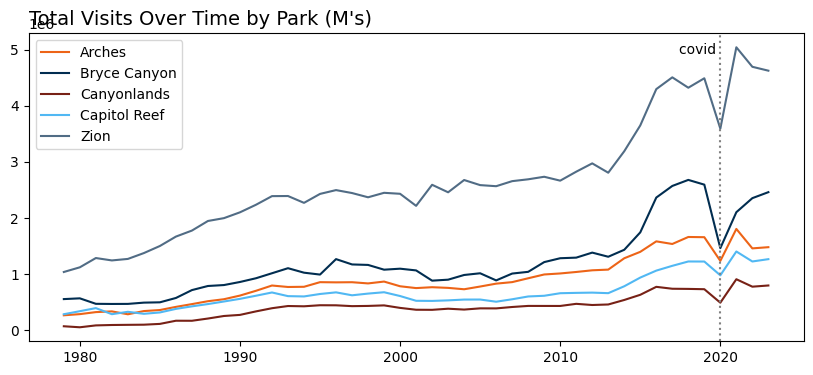

In [56]:
visits_by_year_by_park = (
    df_visit
    .loc[(df_visit['ts'].dt.year < 2024)] #filter current year since it's incomplete
    .groupby([df_visit['ts'].dt.year, 'park'])
    .agg(
        tot_visitors=('visitors', 'sum')
    )
    .reset_index()
    .rename(columns={'ts':'year'})
)

# Create the bar plot
fig, ax = plt.subplots(figsize=(10,4))

i=0

for park, data in visits_by_year_by_park.groupby('park'):
    ax.plot(data['year'], data['tot_visitors'], label=park, color=colors[i])
    i+=1

ax.set_title(
    'Total Visits Over Time by Park (M\'s)',
    fontsize=14,
    loc='left'
)

ax.axvline(2020, color='gray', linestyle=':')
ax.text(2020, 5000000, 'covid ', horizontalalignment='right', verticalalignment='center')

ax.legend()

# Display the plot
plt.show()



In [168]:
type(visits_by_year)

pandas.core.frame.DataFrame